In [1]:
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz

In [2]:
%%capture
%mkdir -p ~/temp
%cd ~/temp

## Enunciado

Considere la información del proyecto cuya información aparece en la tabla adjunta:  


In [3]:
periodo_a_probabilidad = 10
periodo_b_probabilidad = 12
duracion_objetivo = 9
limite_maximo_recursos = 8
pregunta_1 = f"1. ¿Cuál es la probabilidad de terminar el proyecto entre {periodo_a_probabilidad} y {periodo_b_probabilidad} periodos?  "
pregunta_2 = f"2. Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a {duracion_objetivo} periodos.  "
pregunta_3 = f"3. Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de {limite_maximo_recursos} recursos por periodo durante los primeros ocho periodos.  "
pregunta_4 =  "4. Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.  "

In [4]:
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))
display(Markdown(pregunta_4))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 10 y 12 periodos?  

2. Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 9 periodos.  

3. Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros ocho periodos.  

4. Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.  

In [5]:
#| tbl-cap: "Cuadro de datos del enunciado del ejercicio"
#| label: tbl-datosEnunciado

import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, duracion_tope, desviación, coste_planificado, coste_real, duracion_real, realizado, cur, recursos
     ('A',      'D      ',       2,         1,              0.2,         60,              80,          2,           100,   80,    4 ),
     ('B',      'A      ',       2,         1,              0.3,         70,              60,          2,            80,   10,    2 ),
     ('C',      'B      ',       3,         1,              0.4,         50,               0,          0,             0,   40,    1 ),
     ('D',      '---    ',       4,         3,              0.5,         40,              50,          5,           100,   20,    4 ),
     ('E',      'A      ',       1,         1,              0.1,         30,              30,          3,           100,   30,    3 ),
     ('F',      'D,E    ',       2,         1,              0.3,         10,              10,          3,            80,   40,    5 ),
     ('G',      '---    ',       4,         1,              0.1,         40,              50,          3,           100,   20,    4 ),
     ('H',      'G      ',       4,         2,              0.5,        110,             140,          4,            90,   50,    2 ),
     ('I',      'D      ',       2,         1,              0.1,         90,              70,          1,            50,   60,    3 ),
     ('J',      'F,H,I,K',       2,         1,              0.4,         50,               0,          0,             0,   70,    1 ),
     ('K',      'D,G    ',       4,         1,              0.2,         40,              30,          2,            60,   90,    2 ),
     ('L',      'H,K    ',       1,         1,              0.2,         30,               0,          0,             0,   10,    3 ),
] ,columns=['activity', 'predecessor', 'duration', 'cap_duration', 'standard_deviation', 'planned_value', 'actual_cost',
            'actual_duration', 'performed', 'ucr', 'resources']).set_index('activity')
tabla = datos_enunciado.copy()
tabla.columns = ["Pred.", 'Duration', 'Cap <br> duration', 'Standard <br> deviation', 'PV', 'AC',
            'Actual <br> duration', 'Performed', 'UCR', 'Resources']
display(tabla.style.set_properties(**{'text-align': 'center'}).format(precision=2))

,Pred.,Duration,Cap duration,Standard deviation,PV,AC,Actual duration,Performed,UCR,Resources
activity,,,,,,,,,,
A,D,2,1,0.20,60,80,2,100,80,4
B,A,2,1,0.30,70,60,2,80,10,2
C,B,3,1,0.40,50,0,0,0,40,1
D,---,4,3,0.50,40,50,5,100,20,4
E,A,1,1,0.10,30,30,3,100,30,3
F,"D,E",2,1,0.30,10,10,3,80,40,5
G,---,4,1,0.10,40,50,3,100,20,4
H,G,4,2,0.50,110,140,4,90,50,2
I,D,2,1,0.10,90,70,1,50,60,3


{{< pagebreak >}}

## Solución
### Apartado 1

In [6]:
display(Markdown(pregunta_1))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 10 y 12 periodos?  

### Cuadro de prelaciones

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.

In [7]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')

In [8]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L
activities,,,,,,,,,,,,
A,,,,True,,,,,,,,
B,True,,,,,,,,,,,
C,,True,,,,,,,,,,
D,,,,,,,,,,,,
E,True,,,,,,,,,,,
F,,,,,True,,,,,,,
G,,,,,,,,,,,,
H,,,,,,,True,,,,,
I,,,,True,,,,,,,,


### Grafo PERT con numeración de nodos

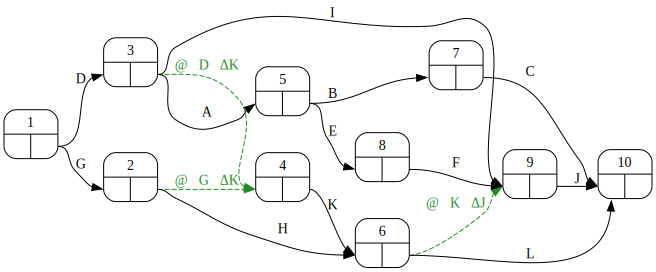

In [9]:
#| fig-cap: "Grafo Pert con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto = prelaciones.create_project()
proyecto.pert()

{{< pagebreak >}}

### Matriz de Zaderenko

In [10]:
#| tbl-cap: "Matriz de Zaderenko para el cálculo de tiempos tempranos y tardíos"
#| label: tbl-Zaderenko
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,early
1,,4.0,4.0,,,,,,,,0.0
2,,,,0.0,,4.0,,,,,4.0
3,,,,0.0,2.0,,,,2.0,,4.0
4,,,,,,4.0,,,,,4.0
5,,,,,,,2.0,1.0,,,6.0
6,,,,,,,,,0.0,1.0,8.0
7,,,,,,,,,,3.0,8.0
8,,,,,,,,,2.0,,7.0
9,,,,,,,,,,2.0,9.0
10,,,,,,,,,,,11.0


Los tiempos tempranos y tardios han resultado ser:

In [11]:
#| tbl-cap: "Valores de los tiempos tempranos y tardíos de los nodos"
#| label: tbl-TempranosTardios
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,4,5
3,4,4
4,4,5
5,6,6
6,8,9
7,8,8
8,7,7
9,9,9
10,11,11


### Duración media del proyecto

In [12]:
duracion_media_proyecto = int(proyecto.duration(durations=datos_proyecto['duration']))
Markdown(f"La información del nodo final del proyecto nos informa de la duración media del proyecto: {duracion_media_proyecto} periodos")

La información del nodo final del proyecto nos informa de la duración media del proyecto: 11 periodos

{{< pagebreak >}}

### Holgura total de las actividades
A partir de los tiempos tempranos y tardíos, y de las duraciones de las actividades, podemos determinar la holgura total de las actividades y con ellas las rutas del camino crítico.

In [13]:
#| tbl-cap: "Valor de la holgura total de las actividades"
#| label: tbl-htotal
resultados_pert['activities']

,H_total
@∇D⤑ΔK,1
@∇G⤑ΔK,1
@∇K⤑ΔJ,1
A,0
B,0
C,0
D,0
E,0
F,0
G,1


### Camino crítico
El camino crítico consta de las siguientes rutas:

In [14]:
proyecto.display_critical_path(durations=datos_proyecto['duration'])

- Route_1 :	A, B, C, D <br> 

- Route_2 :	A, D, E, F, J <br> 

### Calendario del proyecto
Se muestra a continuación el calendario del proyecto, con indicación de las fechas de inicio y fin más tempranas y tardías de cada actividad:

In [15]:
#| tbl-cap: "Calendario del proyecto"
#| label: tbl-calendario
calendario = proyecto.calendar(datos_proyecto['duration'])
calendario

,inicio_mas_temprano,inicio_mas_tardio,fin_mas_temprano,fin_mas_tardio,H_total,duracion
activity,,,,,,
A,4,4,6,6,0,2
B,6,6,8,8,0,2
C,8,8,11,11,0,3
D,0,0,4,4,0,4
E,6,6,7,7,0,1
F,7,7,9,9,0,2
G,0,1,4,5,1,4
H,4,5,8,9,1,4
I,4,7,6,9,3,2


### Grafo PERT con indicación de tiempos y rutas del camino crítico de acuerdo a la planificación inicial
A continuación se muestra el grafo Pert del proyecto, con indicación de las actividades críticas:

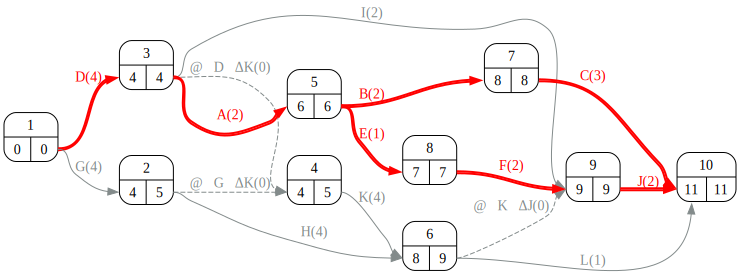

In [16]:
proyecto.pert(durations=datos_proyecto['duration'])

### Caracterización de la duración del proyecto mediante una distribución Normal
A fin de calcular la probabilidad pedida, es necesario caracterizar la distribución Normal de la duración del proyecto. Esto consiste en determinar los valores de sus parámetros: media y desviación típica de la duración del proyecto.

In [17]:
duracion_media_proyecto = int(proyecto.duration(datos_proyecto['duration']))
Markdown(f"La duración media del proyecto ya la tenemos calculada: {duracion_media_proyecto} periodos")

La duración media del proyecto ya la tenemos calculada: 11 periodos

Para determinar la desviación típica debemos obtener en cada rama del camino crítico la suma de las varianzas, y quedarnos con la mayor.

In [18]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto, varianza_rutas = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                   variances=datos_proyecto['variance']) 
desviacion_proyecto = round(desviacion_proyecto, 2)

In [19]:
#| tbl-cap: "Varianza de las rutas del camino crítico"
#| label: tbl-varianzaRutas
varianza_rutas

,Activities,Variance
Route_1,"A, B, C, D",0.54
Route_2,"A, D, E, F, J",0.55


In [20]:
Markdown(f"El proyecto sigue una distribución normal con media {duracion_media_proyecto} periodos y desviación típica {round(desviacion_proyecto, 2)}.")


El proyecto sigue una distribución normal con media 11 periodos y desviación típica 0.74.

#### Probabilidad de terminar entre 10 y 12 periodos

In [21]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_b = round(norm.cdf(periodo_b_probabilidad, loc=duracion_media_proyecto, scale=desviacion_proyecto), 2)
probabilidad_de_terminar_antes_de_a = round(norm.cdf(periodo_a_probabilidad, loc=duracion_media_proyecto, scale=desviacion_proyecto), 2)

probabilidad_de_terminar_entre_a_y_b = probabilidad_de_terminar_antes_de_b - probabilidad_de_terminar_antes_de_a


In [22]:
Markdown(f"""Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad de terminar entre los periodos {periodo_a_probabilidad} y {periodo_b_probabilidad}.  
- La probabilidad de terminar antes de {periodo_a_probabilidad} periodos es  {probabilidad_de_terminar_antes_de_a}  
- La probabilidad de terminar antes de {periodo_b_probabilidad} periodos es {probabilidad_de_terminar_antes_de_b}  

Por tanto, a partir de la diferencia de estos dos valores tenemos la probabilidad de terminar dentro del mencionado intervalo: {int(probabilidad_de_terminar_entre_a_y_b*100)} por ciento.
""")

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad de terminar entre los periodos 10 y 12.  
- La probabilidad de terminar antes de 10 periodos es  0.09  
- La probabilidad de terminar antes de 12 periodos es 0.91  

Por tanto, a partir de la diferencia de estos dos valores tenemos la probabilidad de terminar dentro del mencionado intervalo: 82 por ciento.


### Apartado 2

In [23]:
display(Markdown(pregunta_2))

2. Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 9 periodos.  

#### Reducción a 9 periodos

In [24]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction = duracion_media_proyecto - duracion_objetivo)

In [25]:
#| tbl-cap: "Cuadro del algoritmo de Ackoff Sasieni"
#| label: tbl-ackoffƒ
ackoff

,A,B,C,D,E,F,G,H,I,J,K,L,0,1,2
Route_1,80.0,10.0,40.0,20.0,,,,,,,,,11.0,10.0,9.0
Route_2,80.0,,,20.0,30.0,40.0,,,,70.0,,,11.0,10.0,9.0
Route_3,,,,20.0,,,,,60.0,70.0,,,8.0,7.0,7.0
Route_4,,,,20.0,,,,,,70.0,90.0,,10.0,9.0,9.0
Route_5,,,,20.0,,,,,,,90.0,10.0,9.0,8.0,8.0
Route_6,,,,,,,20.0,50.0,,70.0,,,10.0,10.0,9.0
Route_7,,,,,,,20.0,50.0,,,,10.0,9.0,9.0,8.0
Route_8,,,,,,,20.0,,,70.0,90.0,,10.0,10.0,9.0
Route_9,,,,,,,20.0,,,,90.0,10.0,9.0,9.0,8.0
0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,,,


### Apartado 3

In [26]:
display(Markdown(pregunta_3))

3. Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros ocho periodos.  

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

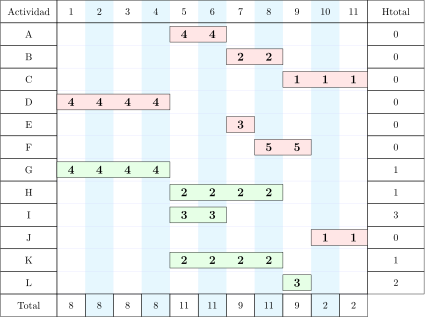

In [27]:
#| fig-cap: "Distribución inicial del consumo de recursos"
#| label: fig-recursosInicial
proyecto_asignacion = proyecto.copy()
gantt, dibujo = proyecto_asignacion.gantt(datos_proyecto,
                          'duration',
                          'resources',
                          total='fila',
                          holguras=True, tikz=True)
pinta_tikz(dibujo)

La fila “Total” obtenida, que podemos representar gráficamente en la siguiente figura, proporciona la información del consumo previsto de recursos a lo largo del tiempo.


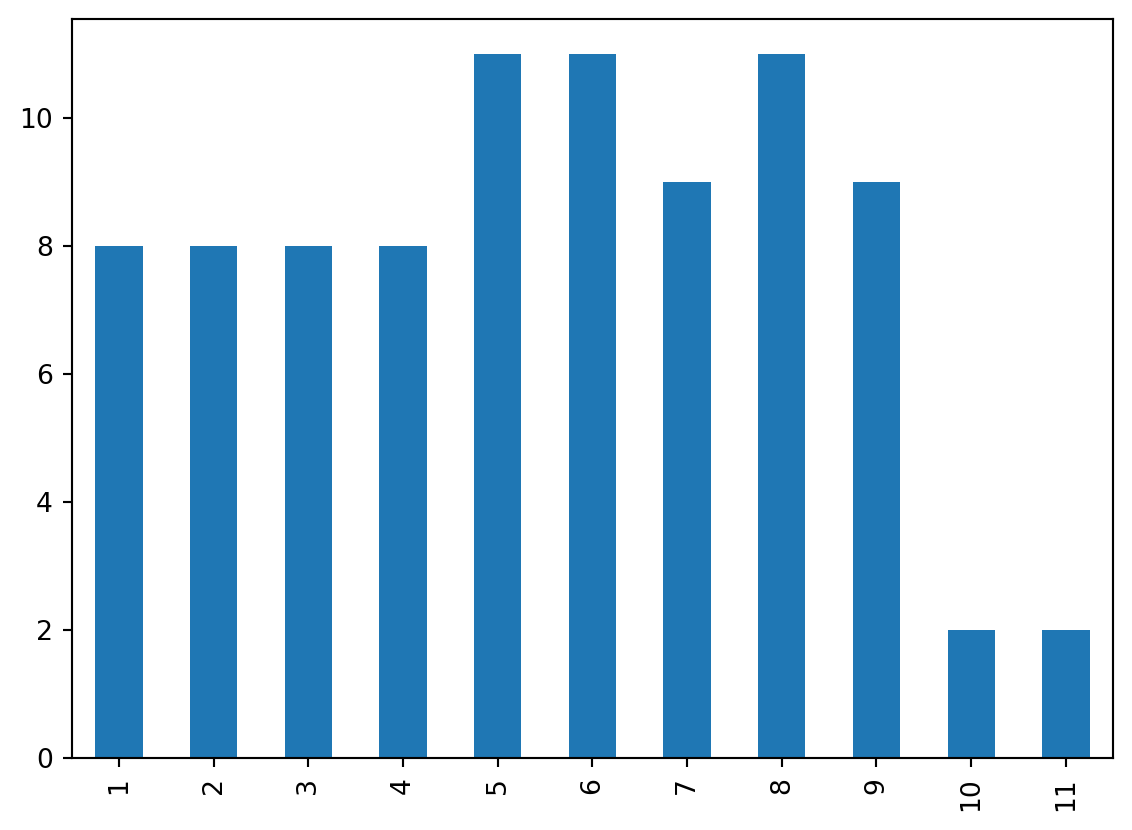

In [28]:
#| fig-cap: "Diagrama de cargas antes de aplicar el algoritmo de asignación"
#| label: fig-preAsignacionBarras
(gantt.data.loc['Total'].drop('H_total').plot(kind='bar'));

La demanda de recursos actual infringe el límite impuesto. Es necesario aplicar el algoritmo de asignación.

### Algoritmo de asignación

In [29]:
duracion_y_recursos = datos_proyecto[['duration', 'resources']]
datos_proyecto_tras_asignacion, gantt_df, dibujo  = proyecto_asignacion.asignar(
                                    data=duracion_y_recursos,
                                    duration_label='duration',
                                    resource_label='resources',
                                    maximo=[limite_maximo_recursos]*8 + [100],
                                    report=False,
                                    )

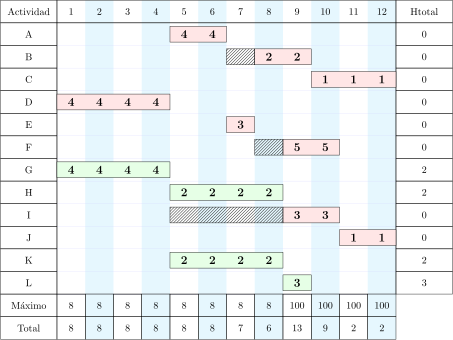

In [30]:
#| fig-cap: "Diagrama de Gantt del proyecto tras la asignación"
#| label: fig-ganttPostAsignación
pinta_tikz(dibujo)

### Apartado 4

In [31]:
display(Markdown(pregunta_4))

4. Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.  

In [32]:
PV = int(datos_proyecto['planned_value'].sum())
EV = int(datos_proyecto.eval('planned_value * performed / 100').sum())
AC = int(datos_proyecto['actual_cost'].sum())
CPI = float(EV/AC)
SPI=float(EV/PV)

In [33]:
Markdown(f"""Utilizando CPI=EV/AC y SPI=EV/PV, tenemos:  
PV={PV}  
EV={EV}  
AC={AC}  
CPI={round(CPI,2)}  
SPI={round(SPI,2)}""")

Utilizando CPI=EV/AC y SPI=EV/PV, tenemos:  
PV=620  
EV=402  
AC=520  
CPI=0.77  
SPI=0.65